In [0]:
import os
import numpy as np
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt
import cv2
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
### Loading VGG19 model.
from tensorflow.keras.applications.vgg19 import VGG19
model = VGG19( 
    weights = 'imagenet', 
    include_top = False
    )
model.trainable = False # Setting layers of VGG19 to non-trainable
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [0]:
class CONFIG:
    IMAGE_WIDTH = 430
    IMAGE_HEIGHT = 398
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.6
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 
    VGG_MODEL = model # Pick the VGG 19-layer model by from the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition".
    STYLE_IMAGE = '/content/drive/My Drive/Colab Notebooks/NST/style.jpg' # Style image to use.
    CONTENT_IMAGE = '/content/drive/My Drive/Colab Notebooks/NST/lotus-1.jpg' # Content image to use.
    OUTPUT_DIR = '/content/drive/My Drive/Colab Notebooks/NST/'

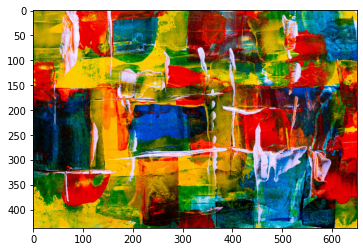

In [0]:
### Resizing style image to shape of content image
style_image = cv2.imread(CONFIG.STYLE_IMAGE)
style_image = cv2.resize(style_image, (650, 437))
style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
plt.imshow(style_image)
plt.imsave('/content/drive/My Drive/Colab Notebooks/NST/style.jpg', style_image)

In [0]:
def load_and_process_image(image_path):
  """
  This function takes an image and processes it to a format which can be 
  fed to VGG19 model.

  Args:
      image_path: path of image which is to be processed.

  Returns:
      image: processed image.
  """
  image = load_img(image_path)
  image = img_to_array(image)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)
  return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


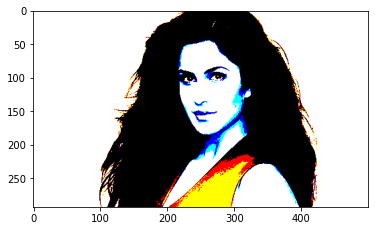

In [0]:
img = load_and_process_image(CONFIG.CONTENT_IMAGE)
plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


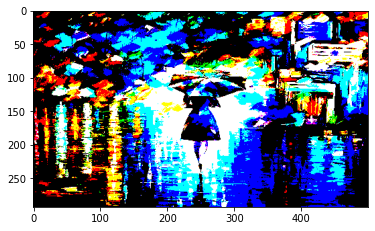

In [0]:
img = load_and_process_image(CONFIG.STYLE_IMAGE)
plt.imshow(img[0])

In [0]:
def deprocess_image(x):
  """
  This fucnction is used to deprocess processed image.

  Args:
      x: x is an image.
    
  Returns:
      x: deprocessed image.
  """
  ### Adding back VGG19 biases 
  x[:,:,0] += 103.939
  x[:,:,1] += 116.779
  x[:,:,2] += 123.68
  x = x[:,:,::-1] # Inverting BGR channels to RGB

  x = np.clip(x, 0, 255).astype('uint8')
  return x

def display_image(image):
  """
  This function will reshape image and call deprocess_image function 
  and then prints image.

  Args:
      image: processed image
  Returns:
      None
  """
  if len(image.shape) == 4:
    image = np.squeeze(image, axis = 0)

  img = deprocess_image(image)

  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  plt.show()

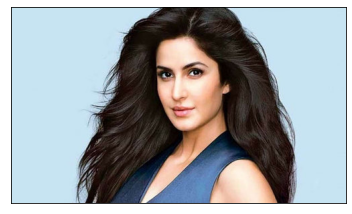

In [0]:
display_image(load_and_process_image(CONFIG.CONTENT_IMAGE))

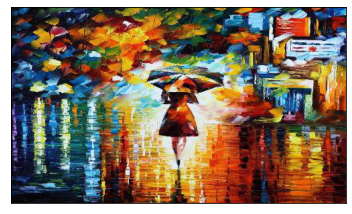

In [0]:
display_image(load_and_process_image(CONFIG.STYLE_IMAGE))

In [0]:
### layer of VGG19 model which will represent content image features
content_layer = 'block5_conv2'

content_model = Model(
    
    inputs = model.input,
    outputs = model.get_layer(content_layer).output
)

In [0]:
### layers of VGG19 model that we will use to stylize content image
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
style_coeff = [0.5, 0.6, 0.8, 0.8, 0.5]

style_models = [
                Model(inputs = model.input,
                      outputs = model.get_layer(layer).output) 
                for layer in style_layers]

In [0]:
def content_cost(content_image, generated_image):
  """
  This function will calculate cost between content and generated images.

  Args:
      content_image: content image.
      generated_image: generated image which will be optimized.

  Returns:
      content_cost: cost between content and generated image.

  """
  a_C = content_model(content_image)
  a_G = content_model(generated_image)
  content_cost = 0.05 * tf.reduce_mean(tf.square(a_C - a_G))
  return content_cost

In [0]:
def gram_matrix(A):
  """
  gram matrix is used to calculate correlation between features of different
  channels

  Args:
      A: it takes an image as input

  Returns:
      GM: gram matrix containning correlation between different pixels

  """
  GM = tf.matmul(A, tf.transpose(A))
  return GM

In [0]:
def style_cost(style_image, generated_image):
  """
  This function will calculate cost between style and generated images.

  Args:
      style_image: style image.
      generated_image: generated image which will be optimized.

  Returns:
      total_style_cost: cost between features of style and generated image.

  """
  total_style_cost = 0

  for i, style_model in enumerate(style_models):
    a_S = style_model(style_image)
    a_G = style_model(generated_image)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    a_S_unrolled = tf.transpose(tf.reshape(a_S, shape=[n_H * n_W, n_C]), perm = [1, 0])
    a_G_unrolled = tf.transpose(tf.reshape(a_G, shape=[n_H * n_W, n_C]), perm = [1, 0])

    GMS = gram_matrix(a_S_unrolled)
    GMG = gram_matrix(a_G_unrolled)

    current_style_cost = 1/4*1/np.square(n_C)*1/np.square(n_H*n_W) * tf.reduce_mean(tf.square(GMS - GMG))

    total_style_cost += style_coeff[i] * current_style_cost

  return total_style_cost


In [0]:
def train(content_image, style_image, alpha = 10, beta =40, Iterations = 2000, lr = 5.0):
  """
  This function will train the model on generated_image

  Args:
      content_image: image  which is to be stylized
      style_image: image which is used to stylize
      alpha: content weight
      beta: style weight
      Iteration: number of iteration
      lr: learning rate

  Returns:
      generate_images: list of stylized images on different iterations
      costs: list of cost at each iteration
  """
  
  content_image_preprocessed = load_and_process_image(CONFIG.CONTENT_IMAGE)
  style_image_preprocessed = load_and_process_image(CONFIG.STYLE_IMAGE)
  generated_image = tf.Variable(content_image_preprocessed, dtype = tf.float32)

  generated_images = []
  costs = []
  optimizer = tf.optimizers.Adam(learning_rate = lr)

  for i in range(Iterations):

    with tf.GradientTape() as tape:
      J_content = content_cost(content_image_preprocessed, generated_image)
      J_style = style_cost(style_image_preprocessed, generated_image)

      J_total = alpha * J_content + beta * J_style

    grads = tape.gradient(J_total, generated_image)
    optimizer.apply_gradients([(grads, generated_image)])

    costs.append(J_total.numpy())

    if i%200 == 0:
      display_image(generated_image.numpy())
      generated_images.append(generated_image.numpy())
      print('Iteration: {}/{}, Total_cost: {}, Style_cost: {}, Content_cost: {}'.format(i+1, Iterations, J_total, J_style, J_content))
  return generated_images, costs


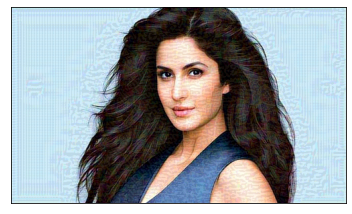

Iteration: 1/2000, Total_cost: 6641.6708984375, Style_cost: 664167.125, Content_cost: 0.0


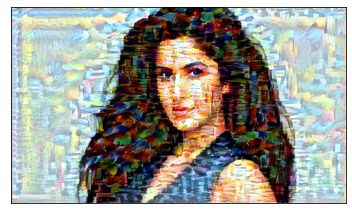

Iteration: 201/2000, Total_cost: 8.024446487426758, Style_cost: 802.051025390625, Content_cost: 393.633056640625


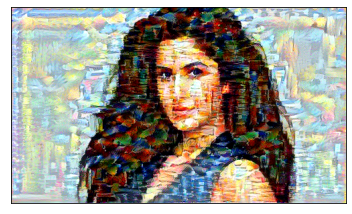

Iteration: 401/2000, Total_cost: 4.722722053527832, Style_cost: 471.8741455078125, Content_cost: 398.0755310058594


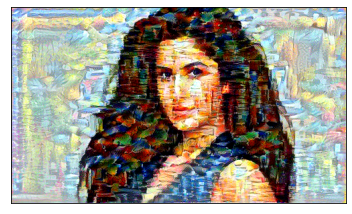

Iteration: 601/2000, Total_cost: 10.042428016662598, Style_cost: 1003.8441772460938, Content_cost: 398.6802978515625


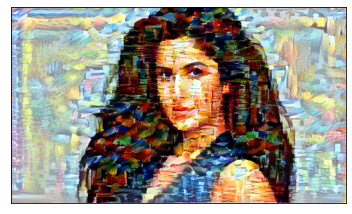

Iteration: 801/2000, Total_cost: 3.8183579444885254, Style_cost: 381.43365478515625, Content_cost: 402.1496276855469


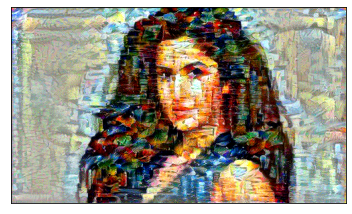

Iteration: 1001/2000, Total_cost: 13.370853424072266, Style_cost: 1336.665283203125, Content_cost: 420.0567932128906


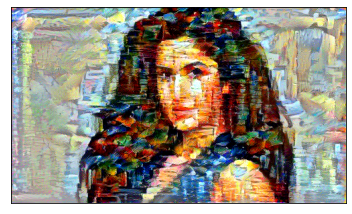

Iteration: 1201/2000, Total_cost: 2.75419020652771, Style_cost: 275.00653076171875, Content_cost: 412.4862365722656


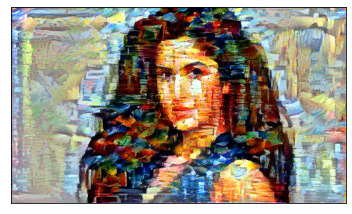

Iteration: 1401/2000, Total_cost: 2.411396026611328, Style_cost: 240.72848510742188, Content_cost: 411.1285095214844


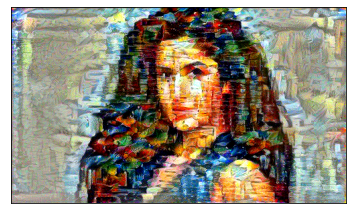

Iteration: 1601/2000, Total_cost: 15.058536529541016, Style_cost: 1505.4388427734375, Content_cost: 414.8467712402344


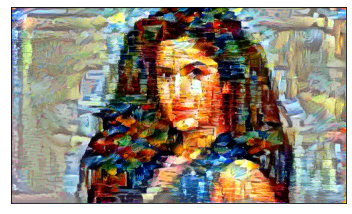

Iteration: 1801/2000, Total_cost: 2.4014949798583984, Style_cost: 239.7351531982422, Content_cost: 414.3572692871094


In [0]:
generated_images, costs = train(CONFIG.CONTENT_IMAGE, CONFIG.STYLE_IMAGE, alpha = 1e-5, beta = 1e-2, lr = 10)

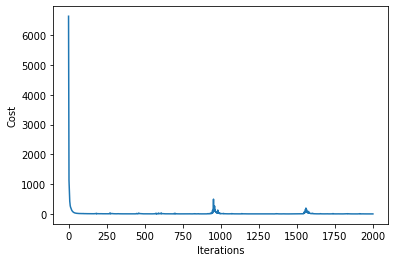

In [0]:
plt.plot(range(2000), costs)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

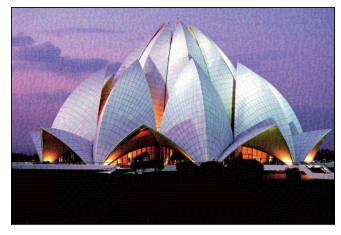

Iteration: 1/2000, Total_cost: 5026.27685546875, Style_cost: 502627.71875, Content_cost: 0.0


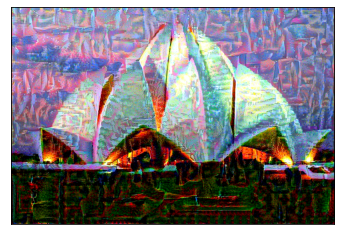

Iteration: 201/2000, Total_cost: 10.688657760620117, Style_cost: 1066.61865234375, Content_cost: 224.71409606933594


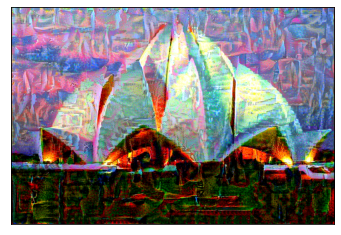

Iteration: 401/2000, Total_cost: 6.167479991912842, Style_cost: 614.4413452148438, Content_cost: 230.6658935546875


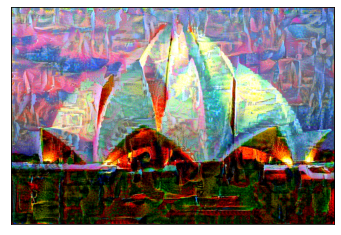

Iteration: 601/2000, Total_cost: 4.414535999298096, Style_cost: 439.1355285644531, Content_cost: 231.8116455078125


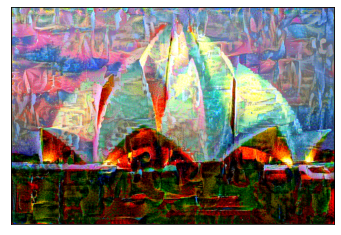

Iteration: 801/2000, Total_cost: 4.411298751831055, Style_cost: 438.7721252441406, Content_cost: 235.7753143310547


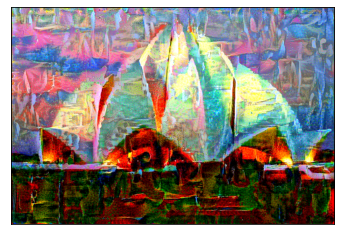

Iteration: 1001/2000, Total_cost: 5.047890663146973, Style_cost: 502.4109191894531, Content_cost: 237.8187255859375


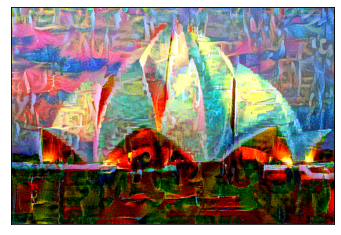

Iteration: 1201/2000, Total_cost: 3.453193426132202, Style_cost: 342.9620361328125, Content_cost: 235.73062133789062


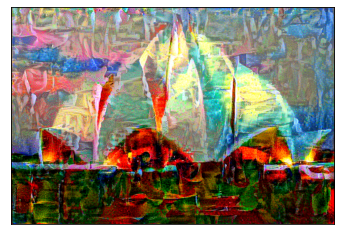

Iteration: 1401/2000, Total_cost: 5.041285514831543, Style_cost: 501.6874084472656, Content_cost: 244.11607360839844


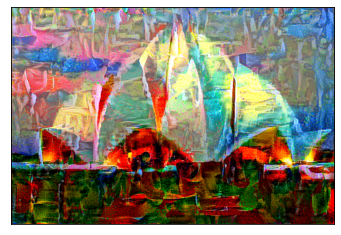

Iteration: 1601/2000, Total_cost: 4.80086088180542, Style_cost: 477.6911926269531, Content_cost: 239.4932403564453


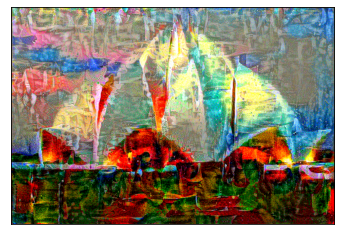

Iteration: 1801/2000, Total_cost: 18.27288055419922, Style_cost: 1824.8236083984375, Content_cost: 246.4532012939453


In [0]:
generated_images_lotus, costs2 = train(CONFIG.CONTENT_IMAGE, CONFIG.STYLE_IMAGE, alpha = 1e-4, beta = 1e-2, lr = 8.0)

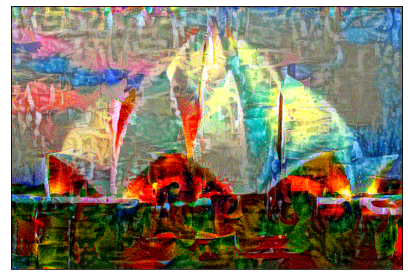

In [0]:
for i in range(len(generated_images_lotus)):
  image = Image.fromarray(deprocess_image(generated_images_lotus[i][0]))
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.tight_layout()
  plt.savefig('/content/drive/My Drive/Colab Notebooks/NST/lotus art/lotus'+str(i)+'.jpg')

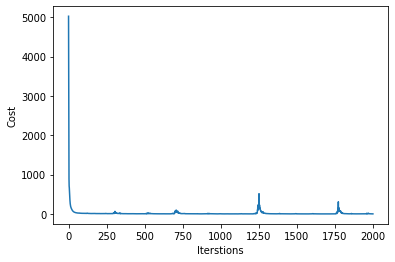

In [0]:
plt.plot(range(2000), costs2)
plt.xlabel('Iterstions')
plt.ylabel('Cost')
plt.show()